In [25]:
%matplotlib inline
import csv
import pandas as pd
import numpy as np
from os import listdir
from os.path import isfile, join
from datetime import date
import re
import matplotlib.pyplot as plt
import PandasHelper as pdh
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")


In [3]:
DATA_PATH = 'data/'
MAIN_FILE = DATA_PATH+'nielsen.csv'

In [4]:
df = pd.read_csv(MAIN_FILE, parse_dates=['first_timeframe'],nrows=1000)
df['date']=df['first_timeframe'].dt.date
df.head(2)

,site_name,first_timeframe,dwell_time_s,device_id,visitor,date
0,BF Karlsruhe Kaiserstr (1122),2014-12-31 23:00:30,15,bd5d8c2890622782d681c82f4dd84db4,True,2014-12-31
1,BF Karlsruhe Kaiserstr (1122),2014-12-31 23:00:40,1080,428fa91d6d741e1466b4bcd917dff4c2,True,2014-12-31


# 1-Create indexes table

In [5]:
def chunk_and_retrieve_indexes():
    chunks = pd.read_csv(MAIN_FILE,chunksize=1000000)
    
    for i,chunk in enumerate(chunks):
        print chunk.shape
        devices_ix = pd.DataFrame(chunk.device_id.unique())
        sites_ix = pd.DataFrame(chunk.site_name.unique())
        devices_ix.to_csv(DATA_PATH+"indexes/devices/devices_ix_"+str(i)+".csv")
        sites_ix.to_csv(DATA_PATH+"indexes/sites/sites_ix_.csv"+str(i)+".csv")

def concatenate_df(df,path):
    df1 = pd.read_csv(path,index_col=0)
   
    return pd.concat([df,df1]).drop_duplicates().reset_index(drop=True)

def concatenate_index_files():
    index_devices_files = pdh.get_files(DATA_PATH+"indexes/devices/")
    index_sites_files = pdh.get_files(DATA_PATH+"indexes/sites/")
    
    df_devices_ix = pd.DataFrame()
    df_sites_ix = pd.DataFrame()
    
    for index_device_file in index_devices_files:
        print index_device_file
        df_devices_ix = concatenate_df(df_devices_ix,DATA_PATH+"indexes/devices/"+index_device_file)
    df_devices_ix.columns=['id','device_mac']
    df_devices_ix.to_csv(DATA_PATH+"indexes/devices_ix.csv")
    
    for index_sites_file in index_sites_files:
        df_sites_ix = concatenate_df(df_sites_ix,DATA_PATH+"indexes/sites/"+index_sites_file)
    df_sites_ix.columns=['id','site_name']
    df_sites_ix.to_csv(DATA_PATH+"indexes/sites_ix.csv")

# 2-replace devices and sites name with ids


In [6]:
def merge_agg_with_device_and_sites_index():
    chunks=pd.read_csv(DATA_PATH+"nielsen.csv",chunksize=1000000)
    df_devices_idx = pd.read_csv(DATA_PATH+"indexes/devices_ix.csv")
    df_sites_index = pd.read_csv(DATA_PATH+"indexes/sites_ix.csv")
    df = pd.DataFrame()
    
    for i,chunk in enumerate(chunks):
        print chunk.shape, i
        chunk = pd.merge(chunk, df_devices_idx, left_on='device_id', right_on='device_mac',suffixes=('_agg', '_devicesidx'))
        chunk = chunk[['id','site_name','first_timeframe']]
        chunk = pd.merge(chunk, df_sites_index, on='site_name', suffixes=('_devices','_sites'))
        chunk=chunk[['id_devices', 'id_sites']]
        chunk=chunk.astype('int32')
        df = pd.concat([df,chunk], axis=0, ignore_index=True)
    print "merge over,starting saving to disk..."
    df.to_csv(DATA_PATH+'/nielsen_indexes.csv')
    print "saved to disk OK."

# 3-Aggregate per devices and site

In [7]:
def aggregate(chunk):
    
    chunk['count']=1
    groupy = chunk.groupby(['id_devices','id_sites']).count()
    groupy = groupy.reset_index()
    
    groupy =groupy.groupby('id_devices')['id_sites'].apply(lambda x: x.tolist())
    return pd.DataFrame(groupy)

def aggregate_per_devices_and_sites():
    chunks = pd.read_csv(DATA_PATH+'/nielsen_indexes.csv',chunksize=40000000,index_col=0)
    df =pd.DataFrame()
    
    for i,chunk in enumerate(chunks):
        df = pd.concat([df,aggregate(chunk)], axis=1, ignore_index=False)
        df = df.fillna(0)
        
        print df.shape,i
    df.to_csv(DATA_PATH+'/nielsen_indexes_pivot.csv')

# 4- Clean data


In [8]:
def combine_sites_id(df):
    cols = df.columns.tolist()
    df = df.replace('0', 0)
    df =df.replace(0,"")
    df = df.fillna("")
    df['sites_id']= df[cols].astype(str).sum(axis=1)
    df['sites_id_array']= df['sites_id'].apply(pdh.string_to_np_array)
    df['sites_count']= df['sites_id_array'].apply(lambda x: x.size)
    df = df[['sites_id_array','sites_count']]
    df.reset_index()
    return df
    
    
def clean_data():
    chunks = pd.read_csv(DATA_PATH+'nielsen_indexes_pivot.csv',chunksize=1000000,index_col=0)
    df = pd.DataFrame()
    
    for i,chunk in enumerate(chunks):
        df = pd.concat([df,combine_sites_id(chunk)],axis=0)
        print df.shape,i
    print "Combining done, saving to file..."
    df.to_csv(DATA_PATH+"nielsen_indexes_sites_per_devices.csv")

# 5- Filter data on devices that appeared on more than one site
once a list of devices/sites/number of sites detected has been created, we can easily filter on devices with multiple site appearances to reduce the dataset of 67%, to a dataset of around 6 millions devices :

In [50]:
def display_spread():
    df = pd.read_csv(DATA_PATH+"/nielsen_indexes_sites_per_devices.csv", index_col=0)
    groupy = df.groupby('sites_count').count()
    total = groupy.sites_id_array.sum(axis=0)
    plt.figure(figsize=(6,6))
    plt.bar(groupy.index,groupy.sites_id_array)
    plt.yscale('log')
    plt.xlabel('Number of sites visited', fontsize=12)
    plt.ylabel('Number of devices (log)', fontsize=12)
    plt.title("Devices per visited sites in the whole year 2015", fontsize=14)
    
def create_mask_on_devices_that_appears_on_multiple_sites():
    df = pd.read_csv(DATA_PATH+"/nielsen_indexes_sites_per_devices.csv", index_col=0)
    mask = pd.DataFrame(df[df.sites_count>2].index.values)
    mask.columns=['device_id']
    
    df_devices_indexes = pd.read_csv(DATA_PATH+"indexes/devices_ix.csv")
    df = pd.merge(mask,df_devices_indexes,left_on="device_id",right_on="id")
    df=df[['device_id','device_mac']]
    df.to_csv(DATA_PATH+"indexes/devices_ix_multiple_sites.csv")

# 6- Merge devices with multiple sites with raw data.

In [10]:
def merge_data(chunk,mask,sites_id):
    chunk = chunk.reset_index()
    chunk['date']=chunk['first_timeframe'].dt.date

    df1 = pd.merge(chunk,mask,left_on='device_id',right_on='device_mac')[['device_id_y','site_name','date']]
    df1 = pd.merge(df1,sites_id,on='site_name')[['device_id_y','id','date']]
    df1.columns = ['device_id','site_id','date']
    return df1

def reduce_data_on_mask():
    devices_id_chunks = pd.read_csv(DATA_PATH+"indexes/devices_ix_multiple_sites.csv", chunksize=500000,index_col=0)
    sites_id = pd.read_csv(DATA_PATH+"indexes/sites_ix.csv",index_col=0)
    sites_id = sites_id.reset_index()  
    
    for i,devices_id_chunk in enumerate(devices_id_chunks):
        data_chunks = pd.read_csv(DATA_PATH+'nielsen.csv',parse_dates=['first_timeframe'],chunksize=1000000,index_col=0)
        print "Merging "+str(i)+" Starts.------------------------------"
        df = pd.DataFrame()
        
        for j,data_chunk in enumerate(data_chunks):
            df = pd.concat([df,merge_data(data_chunk,devices_id_chunk,sites_id)],axis=0)
            print df.shape,j
        print "Finished merging, saving to file..."
        df.to_csv(DATA_PATH+"nielsen_data_multiple_sites_"+str(i)+".csv")

# 7-Group filtered raw data per device-date-site

In [11]:
def final_count(file_name):
    df = pd.read_csv(DATA_PATH+"data_multiples_sites_only_with_indexes/"+file_name,index_col=0)
    result = df.groupby(['device_id','date'])['site_id'].apply(lambda x: (np.unique(x.values).size))
    final = pd.DataFrame(result)
    final.columns=[['count_sites']]
    file_ix = re.findall(r'\d+',file_name)[0]
    final.to_csv(DATA_PATH+"groupby_device_date_site/groupby_device_date_site"+str(file_ix)+".csv")
    
def groupby_device_date_site():
    files = pdh.get_files(DATA_PATH+"data_multiples_sites_only_with_indexes/")
    
    for filo in files:
        print "grouping :"+ filo
        final_count(filo)
    
    groupby_files = pdh.get_files(DATA_PATH+"groupby_device_date_site/")
    df = pd.DataFrame()
    for groupbyfilo in groupby_files:
        df1 = pd.read_csv(DATA_PATH+"groupby_device_date_site/"+groupbyfilo,index_col=0)
        df = pd.concat([df,df1],axis=0)
    df.to_csv(DATA_PATH+"groupby_device_date_site_final.csv")



# 8- Some statistics

In [12]:
def get_dataset_stats():
    chunks = pd.read_csv(DATA_PATH+"nielsen.csv",parse_dates=['first_timeframe'],chunksize=1000000)
    stats =  {}
    min_date = date.today()
    max_date = date(2000,1,1)
    rows =0
    for c in chunks:
        rows+=c.shape[0]
        c.first_timeframe = c.first_timeframe.dt.date
        min_c,max_c = c.first_timeframe.min(), c.first_timeframe.max()
        if min_c < min_date:
            min_date = min_c
        if max_c > max_date:
            max_date = max_c
        print "{:,}".format(rows),min_date,max_date
    stats = {'rows':rows,'min_date':min_date,'max_date':max_date}            
    return stats

def get_number_of_devices():
    df = pd.read_csv(DATA_PATH+"indexes/devices_ix.csv",index_col=0)
    return df.shape[0]

def get_number_of_sites():
    df = pd.read_csv(DATA_PATH+"indexes/sites_ix.csv",index_col=0)
    return df.shape[0]

def get_numbers_records_multi_sites_devices():
    rows = 0
    files = pdh.get_files(DATA_PATH+"data_multiples_sites_only_with_indexes/")
    for filo in files:
        df1 = pd.read_csv(DATA_PATH+"data_multiples_sites_only_with_indexes/"+filo,index_col=0) 
        rows+=df1.shape[0]
    return rows

# <pre>
<center>

| Dataset total records |  167,944,229 |
| :- | :-:
|   Number of devices  | 21,010,205|
|   Number of sites  | 53|
|   Number of devices on more than 1 site (multi-sites devices) | 1,994,526|
|   Records for multi-sites devices  | 47,965,794|
|   Date range of records  | 2014-12-31 to 2015-12-31|

</center>
</pre>

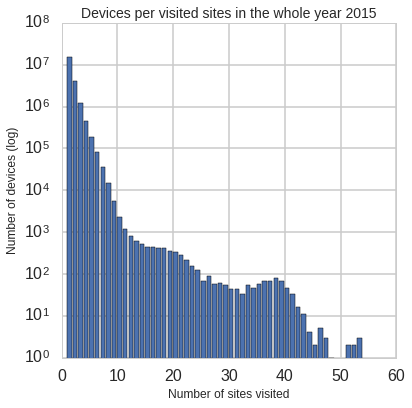

In [51]:
display_spread()